# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
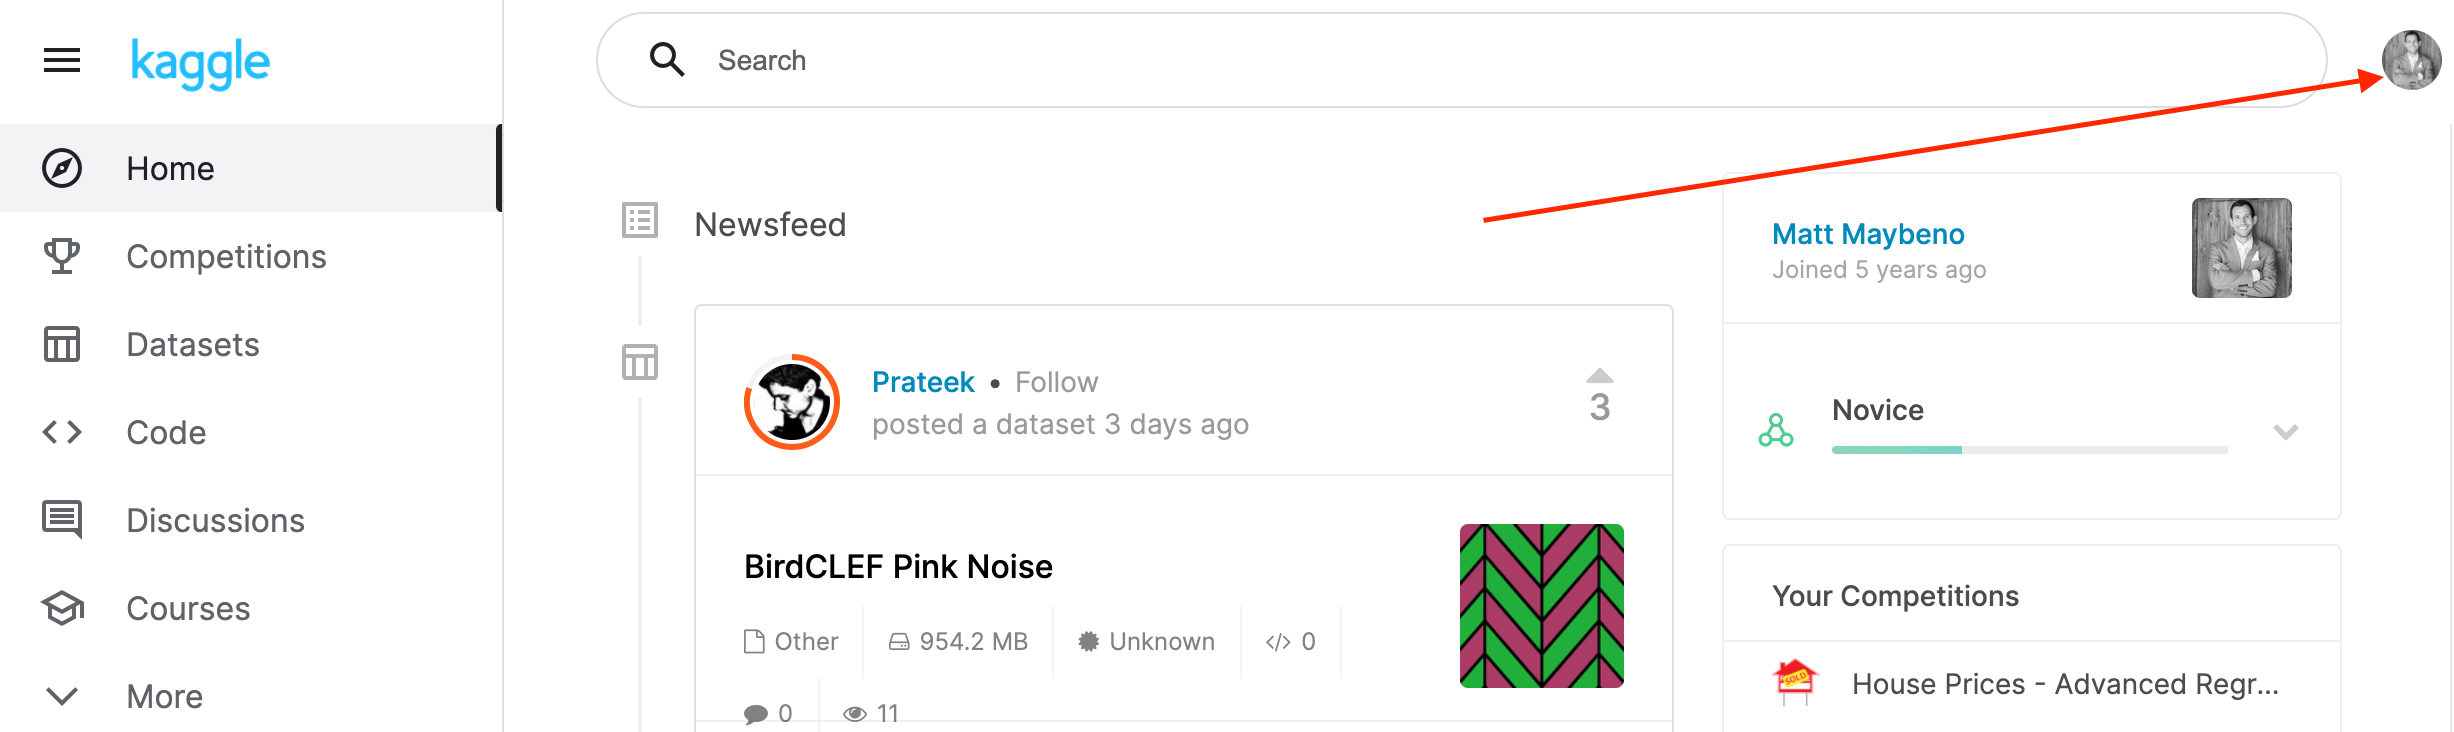
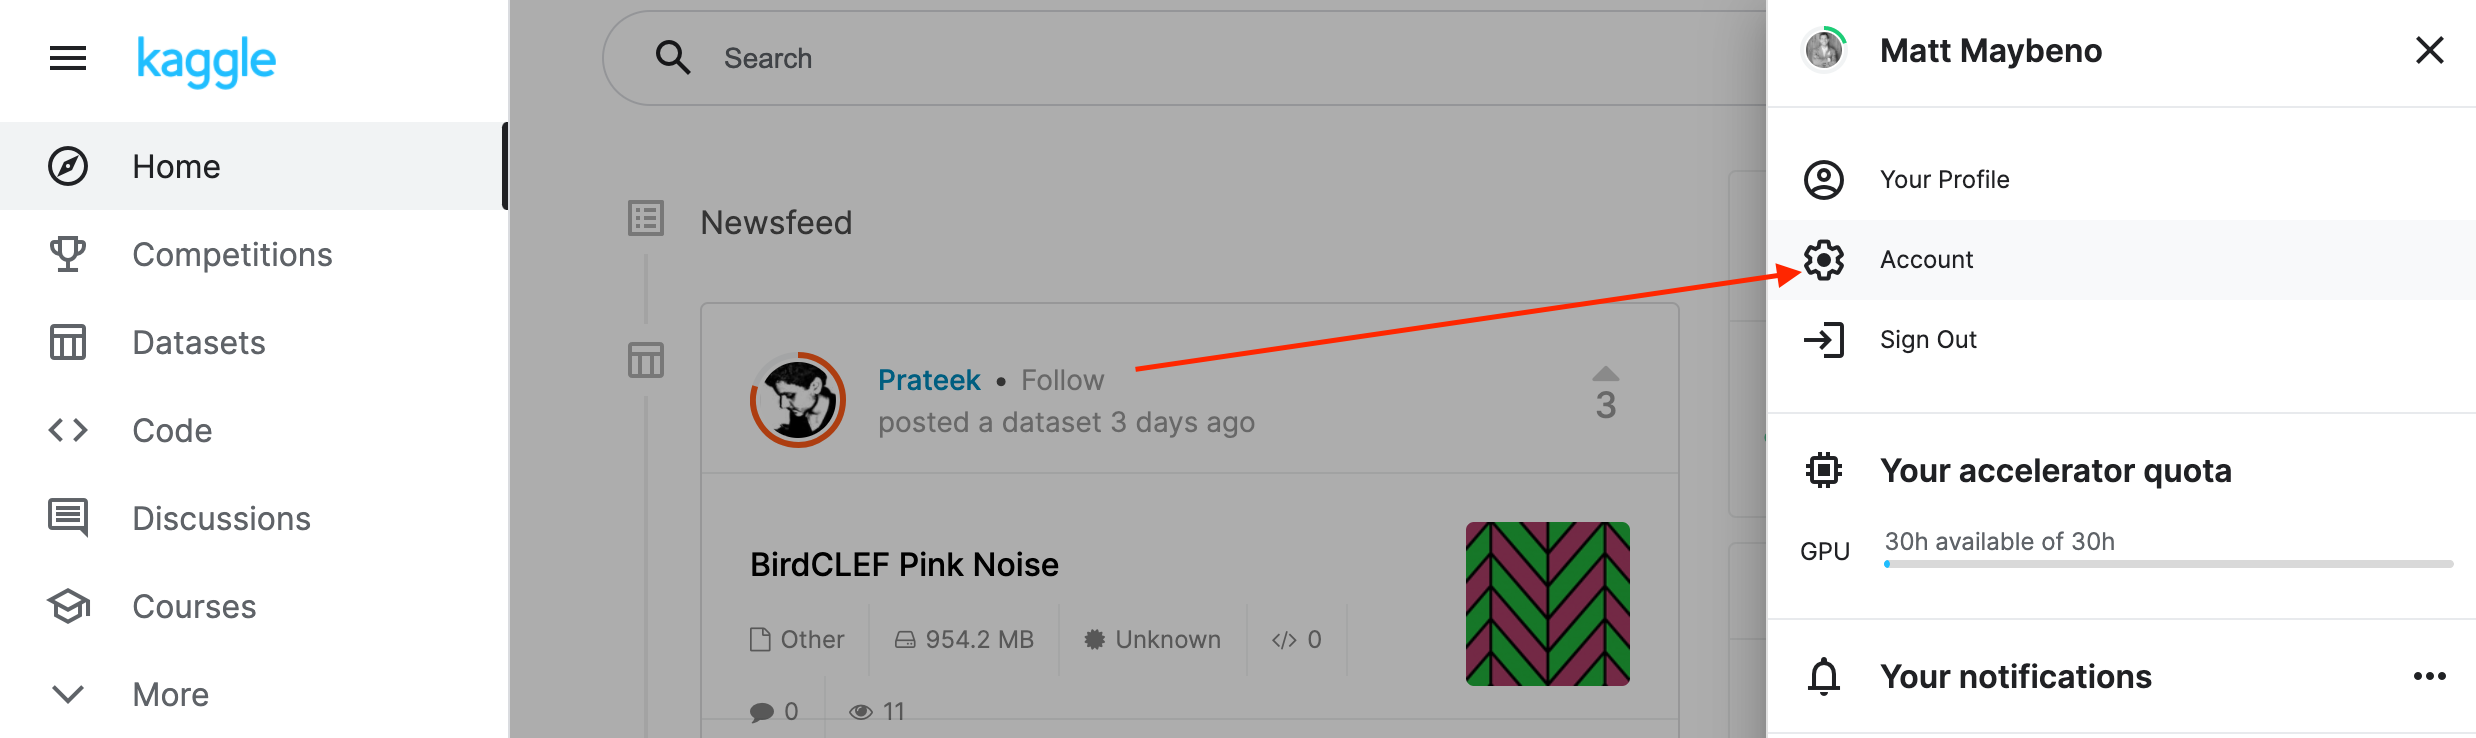
2. Scroll down to API and click Create New API Token.
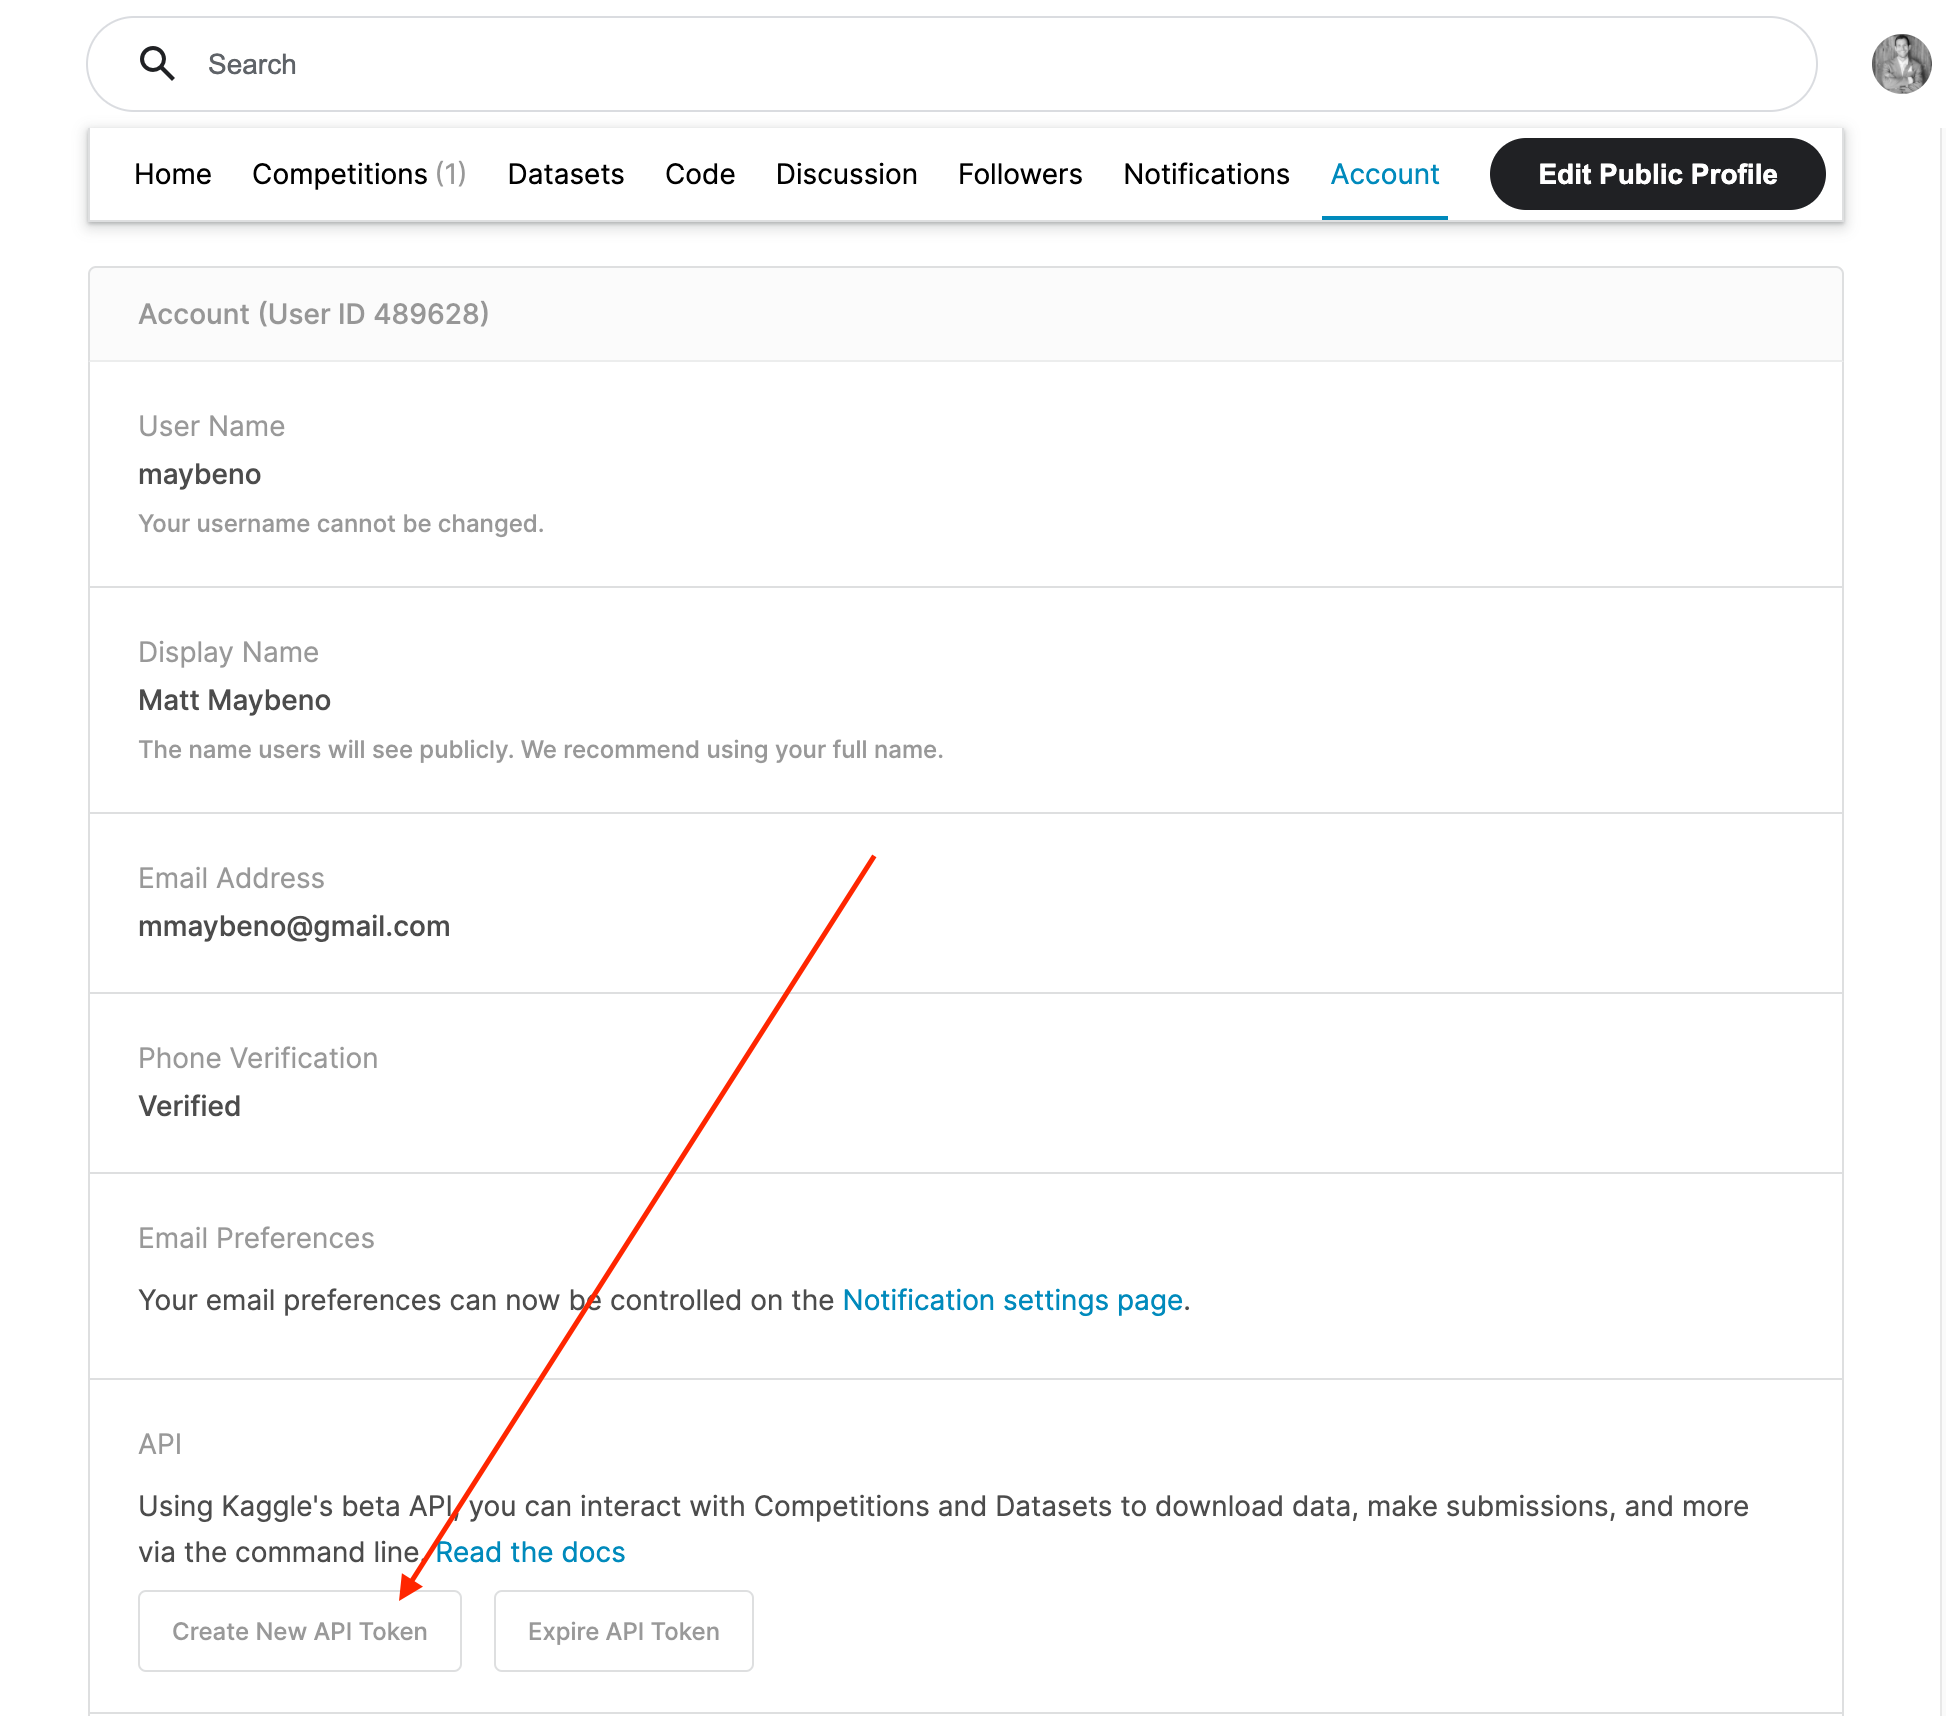
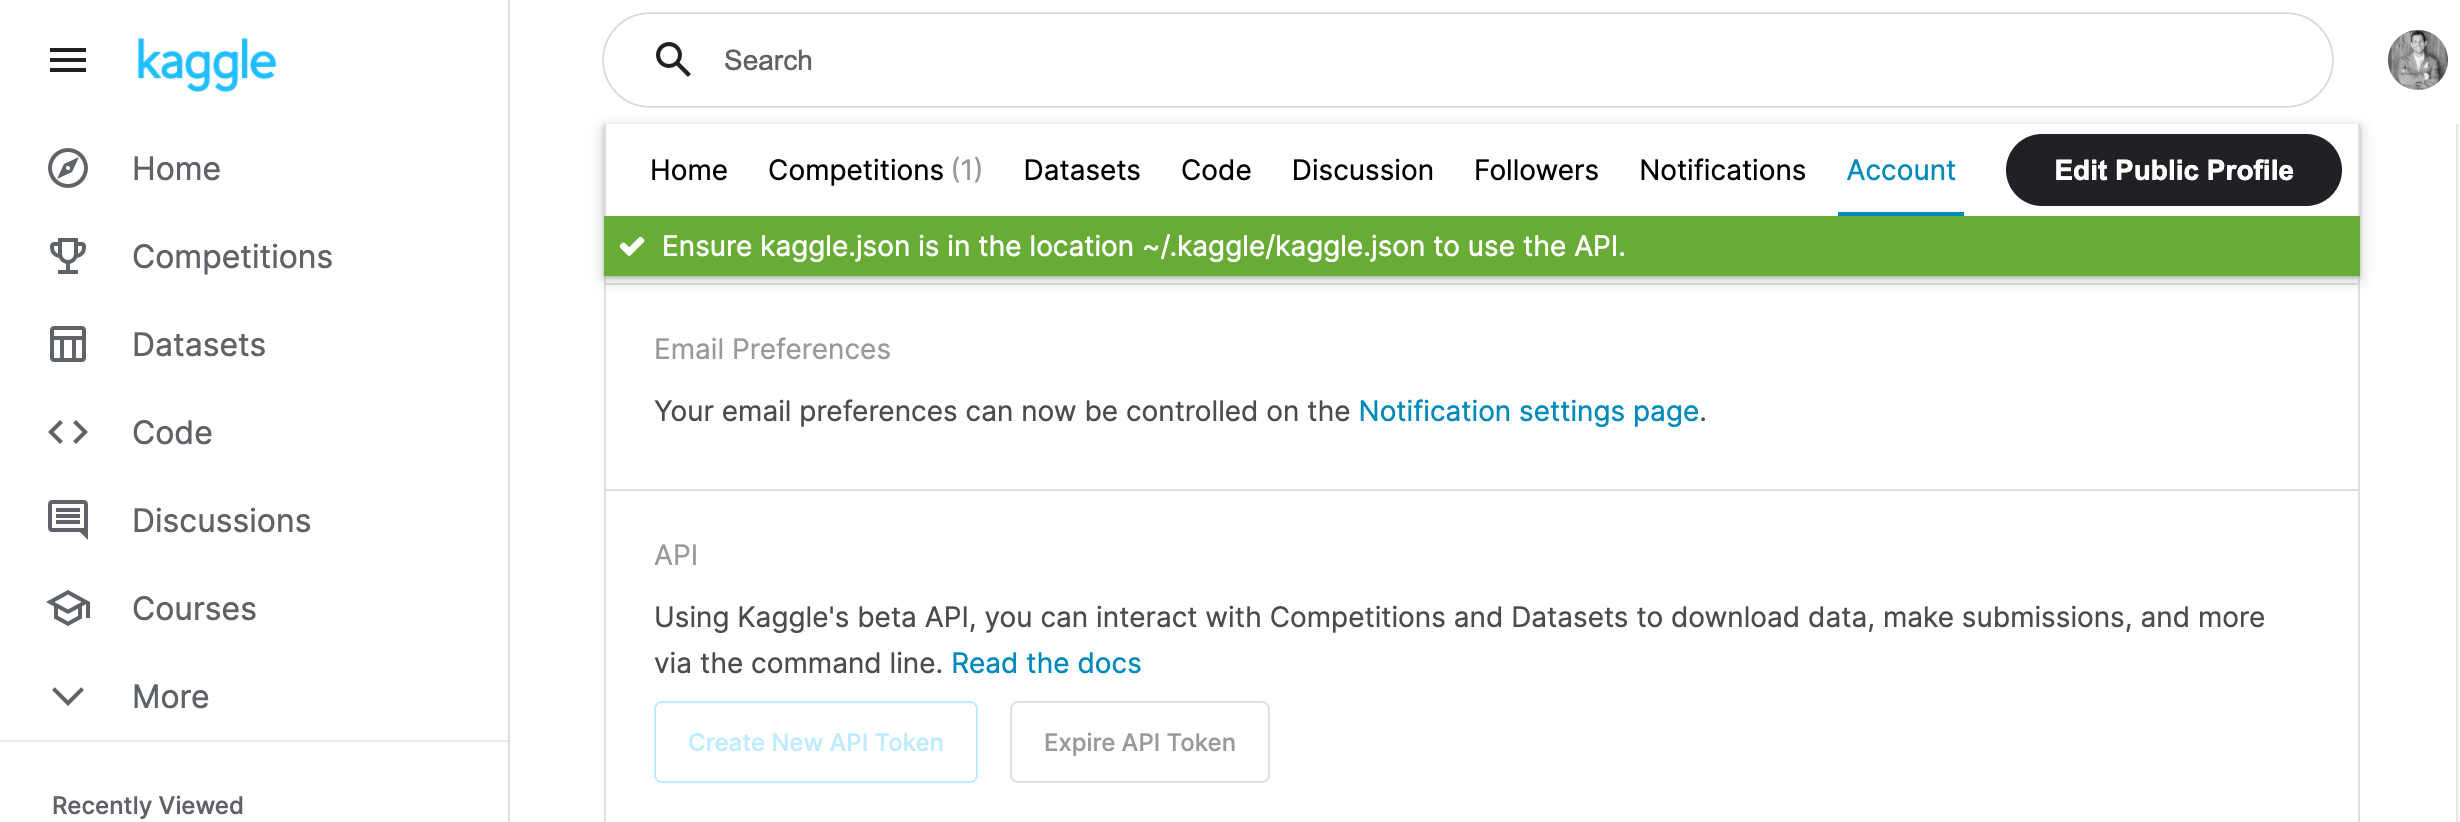
3. Open up `kaggle.json` and use the username and key.
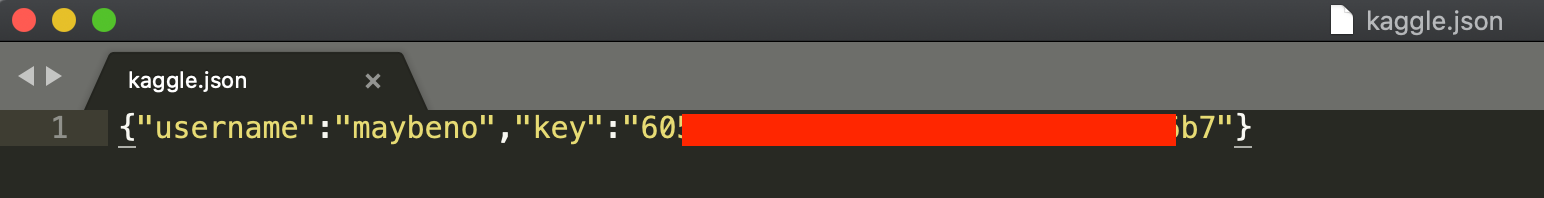

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.0.4-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:0000:01
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.0-py3-none-manylinux2014_x86_64.whl (47.3 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 KB 155.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.2/188.2 KB 203.4 MB/s

In [3]:
!pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-6.1.1-py2.py3-none-any.whl (9.1 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "sacchimishra"
kaggle_key = "b6f0ee246157a276c195c24b0a4393c8"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
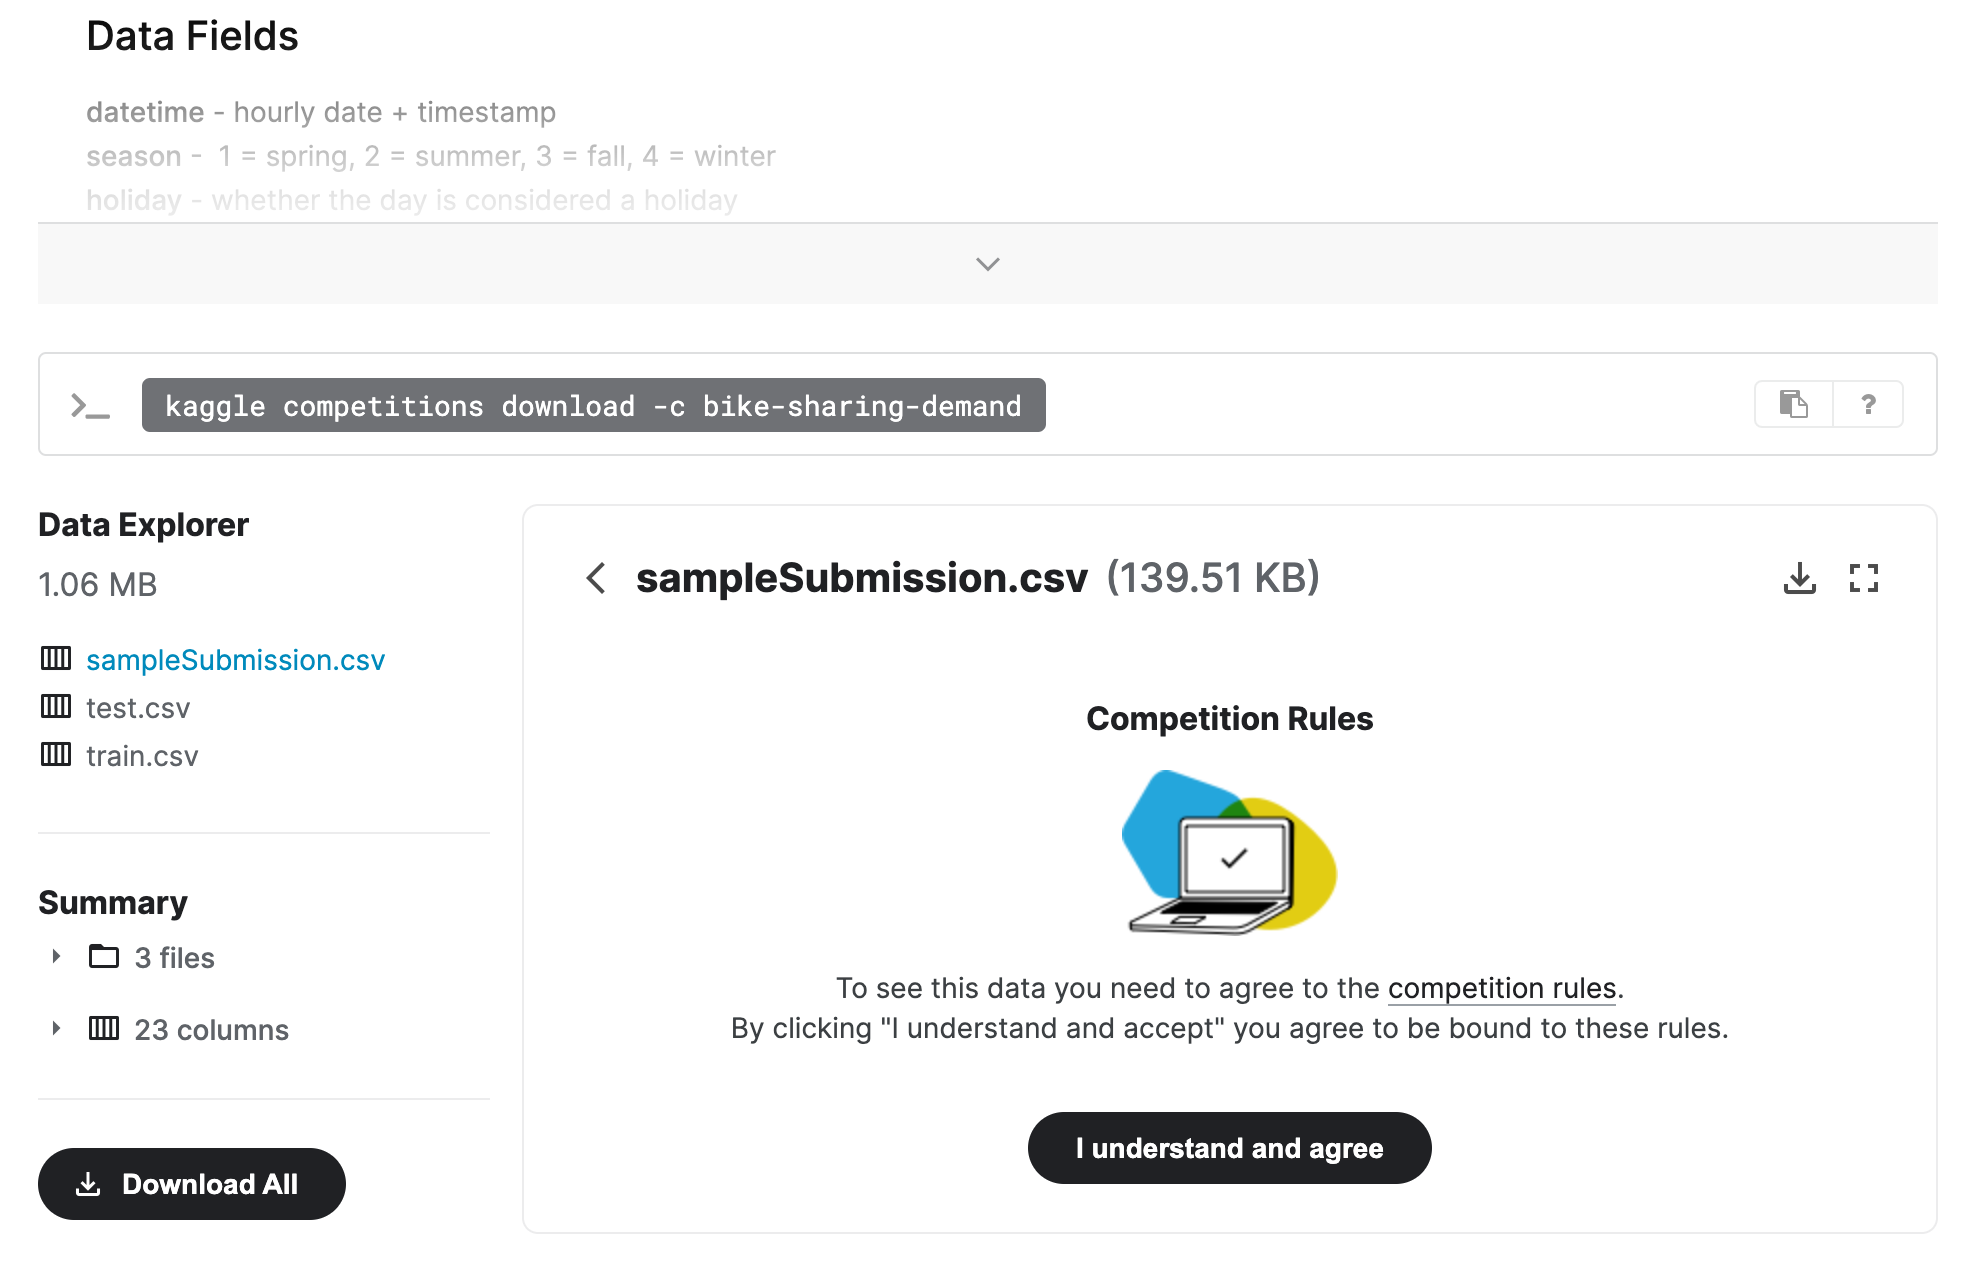

In [20]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

# unzip command not available in the current instance. Hence individual files were uploaded 
# manually from local machine.

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
/bin/sh: 1: unzip: not found


In [6]:
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("./project/bike-sharing-demand/train.csv", parse_dates=['datetime'])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

### Understanding the Data
#### Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [6]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

### EDA of Train Dataset
**Data visualization**

In [35]:
def save_fig(fig_name):
    fig_dir = './project/figures'
    fname = os.path.join(fig_dir, fig_name+'.png')
    plt.savefig(fname, dpi=300)
    #Bike-sharing-demand-final/project/figures
def save_df(df, csv_name):
    csv_dir = './project/tables'
    fname = os.path.join(csv_dir, csv_name +'.csv')
    df.to_csv(fname, index=False)

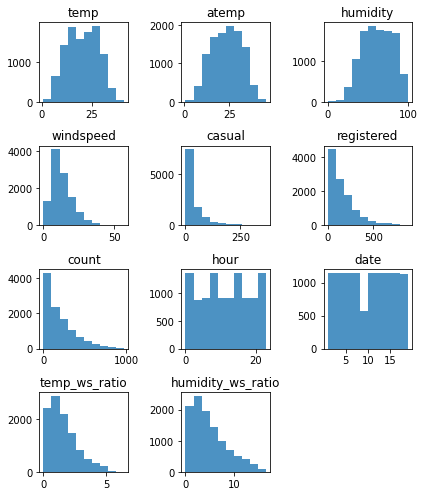

In [36]:
_ = train[train.columns[1:]].hist(figsize=(6,7), grid=False, alpha=0.8)
plt.tight_layout()
save_fig('feature_distribution_raw')    

In [34]:
!cd .
!ls

CODEOWNERS   img		     project-template.ipynb
LICENSE.txt  project		     project_report.md
README.md    project-notebook.ipynb  report-template.md


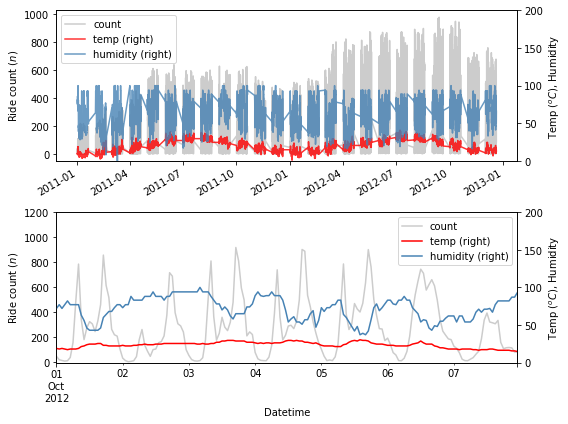

In [37]:
train.index = train['datetime']

fig, axes = plt.subplots(2,1, figsize=(8, 6))
train[['count']].plot(color='0.8',ax=axes[0])
train[['temp', 'humidity']].plot(secondary_y=True, color=['r','steelblue'], alpha=0.8, ax=axes[0])
axes[0].right_ax.set_ylim(0, 200)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ride count ($n$)')
axes[0].right_ax.set_ylabel('Temp (${^oC}$), Humidity')

train['2012-10-01':'2012-10-07'][['count']].plot(color='0.8',ax=axes[1])
train['2012-10-01':'2012-10-07'][['temp', 'humidity']].plot(secondary_y=True, color=['r','steelblue'], ax=axes[1])
axes[1].set_ylim(-5, 1200)
axes[1].right_ax.set_ylim(0, 200)
axes[1].set_ylabel('Ride count ($n$)')
axes[1].right_ax.set_ylabel('Temp (${^oC}$), Humidity')
axes[1].set_xlabel('Datetime')

plt.tight_layout()
save_fig('Bike_sharing_data_ts_plot')

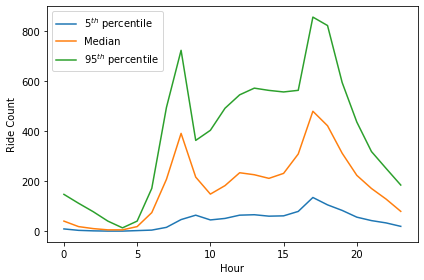

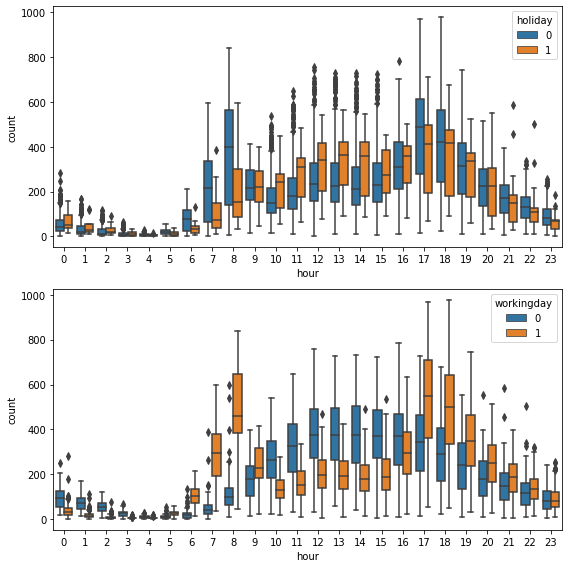

In [38]:
train['hour'] = train.datetime.dt.hour

# Line plot
train.groupby('hour')['count'].quantile(0.05).plot(label = "5$^{th}$ percentile")
train.groupby('hour')['count'].quantile(0.5).plot(label = "Median")
train.groupby('hour')['count'].quantile(0.95).plot(label = "95$^{th}$ percentile")
plt.xlabel('Hour')
plt.ylabel('Ride Count')
plt.legend()
plt.tight_layout()
save_fig('RideCount_dist_by_hour')

# Boxplot
fig, axes = plt.subplots(2,1,figsize=(8,8))
sns.boxplot(x='hour', y='count', data=train, hue='holiday', ax=axes[0])
sns.boxplot(x='hour', y='count', data=train, hue='workingday', ax=axes[1])
plt.tight_layout()
save_fig('hourly_count_distplot')

***How the features are correlated among each other?***

In [39]:
# Calculate correlation between the features and the target
corr_df = train.corr()
save_df(corr_df, 'correlation_df')
corr_df

temp     atemp  humidity  windspeed    casual  \
temp               1.000000  0.984948 -0.064949  -0.017852  0.467097   
atemp              0.984948  1.000000 -0.043536  -0.057473  0.462067   
humidity          -0.064949 -0.043536  1.000000  -0.318607 -0.348187   
windspeed         -0.017852 -0.057473 -0.318607   1.000000  0.092276   
casual             0.467097  0.462067 -0.348187   0.092276  1.000000   
registered         0.318571  0.314635 -0.265458   0.091052  0.497250   
count              0.394454  0.389784 -0.317371   0.101369  0.690414   
hour               0.145430  0.140343 -0.278011   0.146631  0.302045   
date               0.015551  0.011866 -0.011335   0.036157  0.014109   
temp_ws_ratio      0.512140  0.507458  0.097588  -0.188568  0.182659   
humidity_ws_ratio -0.018394 -0.008816  0.495377  -0.267664 -0.169697   

                   registered     count      hour      date  temp_ws_ratio  \
temp                 0.318571  0.394454  0.145430  0.015551       0.512140   
atemp                0.314635  0.389784  0.140343  0.011866       0.507458   
humidity            -0.265458 -0.317371 -0.278011 -0.011335       0.097588   
windspeed            0.091052  0.101369  0.146631  0.036157      -0.188568   
casual               0.497250  0.690414  0.302045  0.014109       0.182659   
registered           1.000000  0.970948  0.380540  0.019111       0.116639   
count                0.970948  1.000000  0.400601  0.019826       0.147632   
hour                 0.380540  0.400601  1.000000  0.001132       0.032807   
date                 0.019111  0.019826  0.001132  1.000000       0.022874   
temp_ws_ratio        0.116639  0.147632  0.032807  0.022874       1.000000   
humidity_ws_ratio   -0.136358 -0.160499 -0.143958  0.009743       0.708159   

                   humidity_ws_ratio  
temp                       -0.018394  
atemp                      -0.008816  
humidity                    0.495377  
windspeed                  -0.267664  
casual                     -0.169697  
registered                 -0.136358  
count                      -0.160499  
hour                       -0.143958  
date                        0.009743  
temp_ws_ratio               0.708159  
humidity_ws_ratio           1.000000

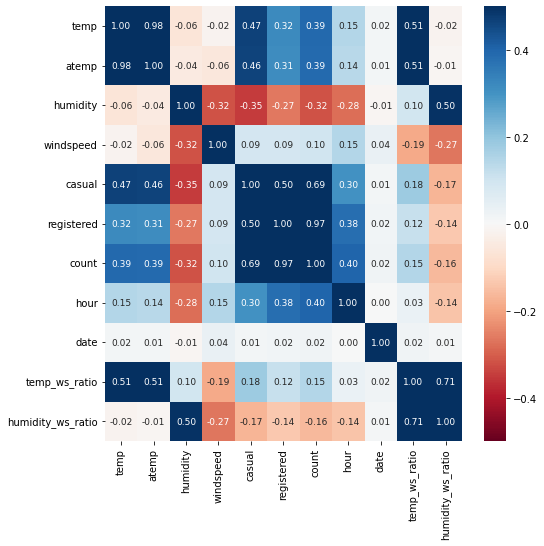

In [40]:
from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Use a diverging palette to visualize r
divnorm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
sns.heatmap(corr_df, annot=True, norm=divnorm, annot_kws={"size": 9}, fmt=".2f", ax=ax, cmap='RdBu')
save_fig('correlation_heatmap')

***Key observations***
- count is positively correlated with temperature and feels-like temperature, which means people warmer days for biking.
- count is negatively correlated with humidity
- correlation between count and categorical features such as season, holiday, working day, and weather are spurious due to obvious reasons

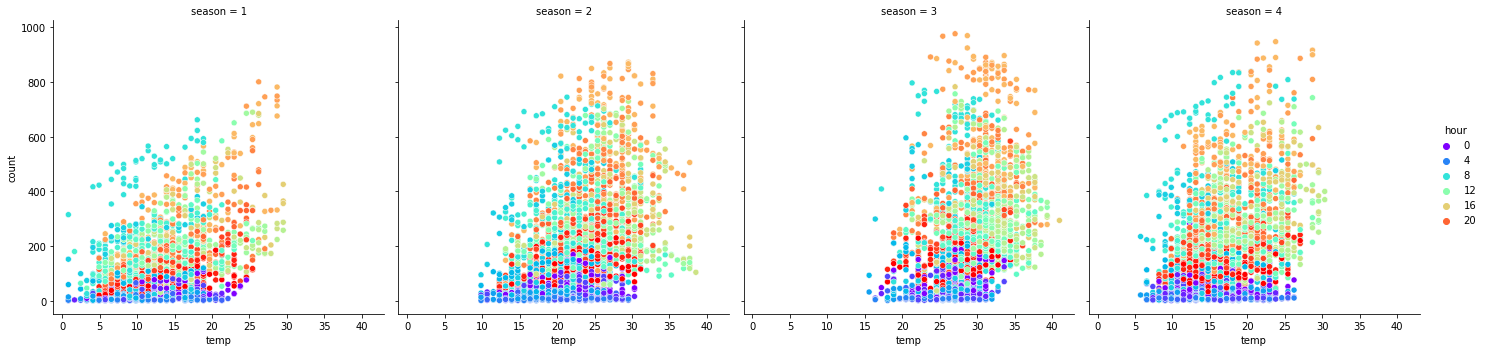

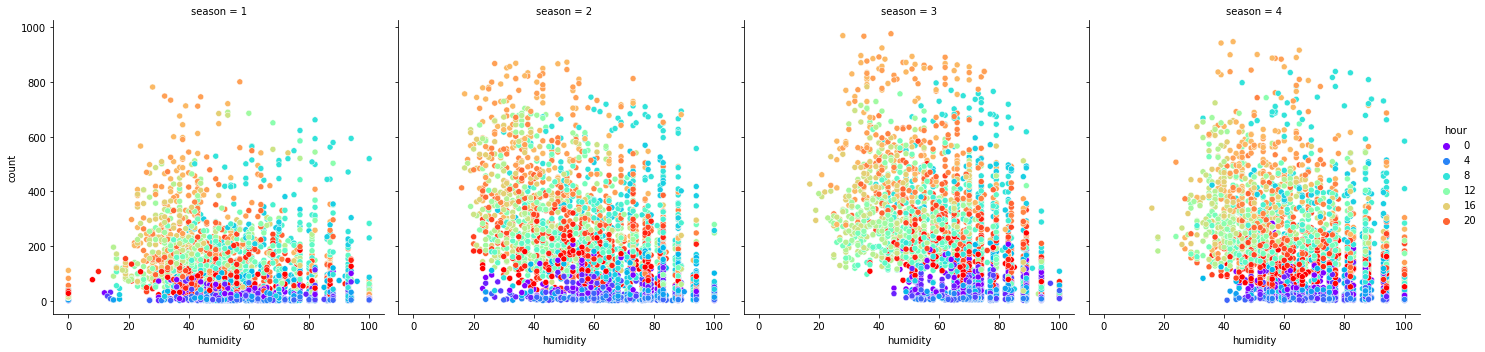

In [42]:
sns.relplot(x='temp', y='count', data=train, hue='hour', col='season', kind='scatter', palette='rainbow')
save_fig('temp_vs_count_by_season')
sns.relplot(x='humidity', y='count', data=train, hue='hour', col='season', kind='scatter', palette='rainbow')
save_fig('humidity_vs_count_by_season')
#sns.relplot(x='windspeed', y='count', data=train, hue='hour', col='season', kind='scatter', palette='rainbow')

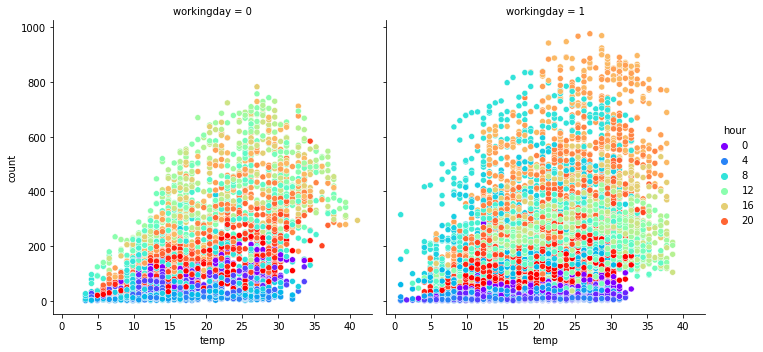

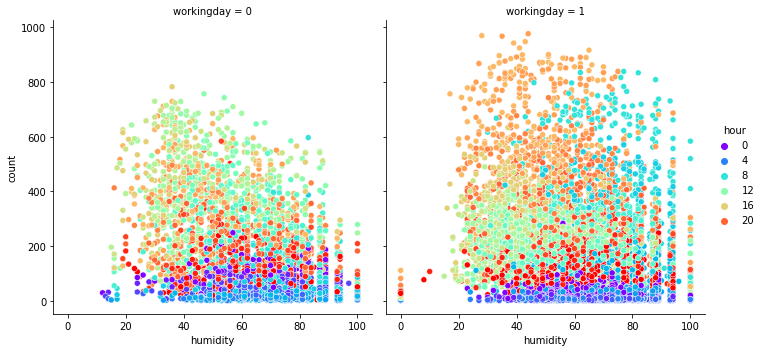

In [42]:
sns.relplot(x='temp', y='count', data=train, hue='hour', col='workingday', kind='scatter', palette='rainbow')
sns.relplot(x='humidity', y='count', data=train, hue='hour', col='workingday', kind='scatter', palette='rainbow')
#sns.relplot(x='windspeed', y='count', data=train, hue='hour', col='workingday', kind='scatter', palette='rainbow')

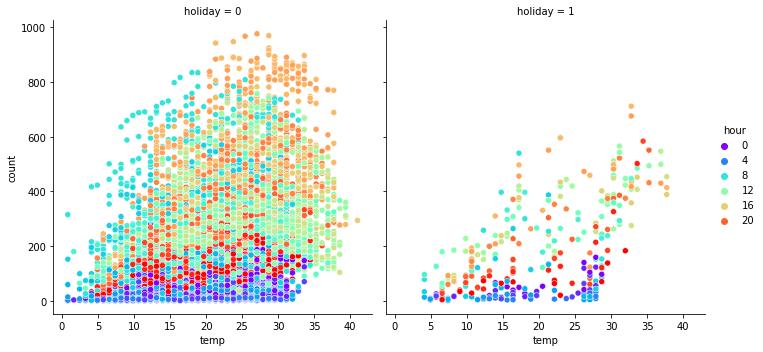

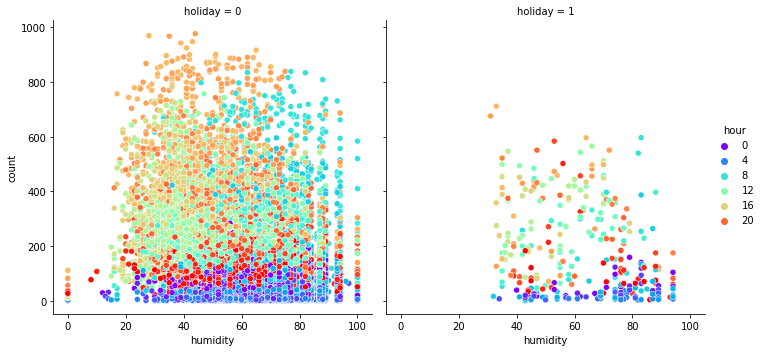

In [43]:
sns.relplot(x='temp', y='count', data=train, hue='hour', col='holiday', kind='scatter', palette='rainbow')
sns.relplot(x='humidity', y='count', data=train, hue='hour', col='holiday', kind='scatter', palette='rainbow')

In [43]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./project/bike-sharing-demand/test.csv", parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [11]:
# Same thing as train and test dataset
submission = test.copy(deep=True)
submission.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
# Exclude 'casual' and 'registered' columns
feature_columns = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']

In [25]:
predictor = TabularPredictor(problem_type="regression", eval_metric="root_mean_squared_error", label="count").fit(
    train_data=train[feature_columns],
    time_limit=600,
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220405_171744/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220405_171744/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2921.86 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityF

### Review AutoGluon's training run with ranking of models that did the best.

In [26]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.801702      10.746370  506.755593                0.001115           0.376813            3       True         15
1   RandomForestMSE_BAG_L2  -53.383134       9.869673  407.044196                0.500367          25.398833            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.764044       9.871635  388.836946                0.502329           7.191583            2       True         14
3          LightGBM_BAG_L2  -55.107515       9.632437  403.824630                0.263132          22.179267            2       True         11
4          CatBoost_BAG_L2  -55.471818       9.479427  451.609097                0.110121          69.963734            2       True         13
5        LightGBMXT_BAG_L2  -60.258950      12.620328  434.019982         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [32]:
predictions = predictor.predict(test[feature_columns[:-1]])
predictions.head()

0    23.608570
1    40.731003
2    45.228043
3    48.172649
4    50.813995
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [33]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.810585
std        90.239227
min         3.087319
25%        20.333408
50%        63.093567
75%       168.992218
max       362.533722
Name: count, dtype: float64

In [34]:
# How many negative values do we have?
predictions[predictions<0].count()

0

In [ ]:
# Set them to zero
#predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [45]:
submission["count"] = predictions
submission[["datetime", "count"]].to_csv("submission.csv", index=False)


In [46]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 456kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [47]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-04-05 17:50:46  first raw submission  complete  1.80492      1.80492       
submission.csv  2022-04-05 17:49:16  first raw submission  error     None         None          


#### Initial score of 1.804

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

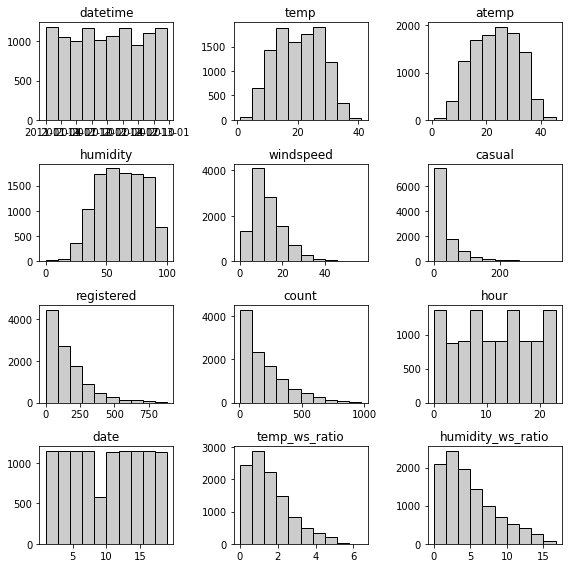

In [44]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
_ = train.hist(color='0.8', edgecolor='k', grid=False,figsize=(8,8))
plt.tight_layout()
save_fig('data_distribution_ii')

In [45]:
def add_holiday_rushhour(holiday, hour):
    """
    Codes rushour classes (1-most rush, 5-least rush)
    holiday_rushhour: 
    16-18 (1)
    12-14 (2)
    8-9 (3)
    1-5 (4)
    all others (5) 
    """        
    if (holiday==1) & (hour in range(16, 19)):
        rush_class = 1
    elif (holiday==1) & (hour in range(12,15)):
        rush_class = 2
    elif (holiday==1) & (hour in range(8,10)):
        rush_class = 3
    elif (holiday==1) & (hour in range(0,6)):
        rush_class = 5
    elif (holiday==1) & (hour in [6,7,11,15,20,21,22,23]):
        rush_class = 4
    else:
        rush_class= 0

    return rush_class

def add_workday_rushhour(workingday, hour):
    """
    Codes rushour classes (1-most rush, 5-least rush) 
    workday_rushhour: 
    17-19 (1)
    7-8 (2)
    8-9 (3)
    1-5 (4)
    all others (5)  
    """
    if (workingday==1) & (hour in range(17,20)):
        rush_class = 1
    elif (workingday==1) & (hour in range(7,9)):
        rush_class = 2
    elif (workingday==1) & (hour in range(8,10)):
        rush_class = 3
    elif (workingday==1) & (hour in [6,7,11,12,13,14,15,16,20,21,22,23]):
        rush_class = 4
    elif (workingday==1) & (hour in range(0,6)):
        rush_class = 5
    else:
        rush_class = 0
    return rush_class

def add_weekend_rushhour(workingday, hour, temp):
    """
    Codes rushour classes (1-most rush, 5-least rush) 
    workday_rushhour: 
    17-19 (1)
    7-8 (2)
    8-9 (3)
    1-5 (4)
    all others (5)  
    """
    if (workingday==0) & (hour in range(10,20)):
        rush_class = 1
    elif (workingday==0) & (hour in range(0,6)):
        rush_class = 3
    elif (workingday==0) & (hour in [6,7,8,9,21,22,23]):
        rush_class = 2
    else:
        rush_class = 0
        
    return rush_class
        
        
def lets_bike(holiday_rush_hour, workday_rush_hour, weekend_rush_hour, hour):
    """ most favorable for biking or not based on weather, temperature and hushhour info
    let's go fo rbike if: holiday_rushhour, workday rushhour, weekend rushhour + temp >15
    """
    if (workday_rush_hour in [1,2]) | (weekend_rush_hour == 1):
        code = 1
    elif hour in range(0,6): 
        code = 0
    else:
        code= 2
    return code

def temp_ws_ratio(temp, ws):
    """Calculates temperature to windspeed ratio"""
    if ws == 0:
        ratio = 0
    else:
        ratio = temp/ws
    return ratio

def humidity_ws_ratio(humidity, ws):
    """Calculates humidity to windspeed ratio"""
    if ws == 0:
        ratio = 0
    else:
        ratio = humidity/ws
    return ratio


In [46]:
# Add new feature to train data
train['hour'] = train.datetime.dt.hour
train['date'] = train.datetime.dt.day
train['month'] = train.datetime.dt.month
train['dow'] = train.datetime.dt.dayofweek
train['day'] = train.datetime.dt.day
train['holiday_rush_hour'] = train.apply(lambda train: add_holiday_rushhour(train['holiday'], train['hour']), axis=1)
train['workday_rush_hour'] = train.apply(lambda train: add_workday_rushhour(train['workingday'], train['hour']), axis=1)
train['weekend_rush_hour'] = train.apply(lambda train: add_weekend_rushhour(train['workingday'], train['hour'], train['temp']), axis=1)
train['lets_bike'] = train.apply(lambda train: lets_bike(train['holiday_rush_hour'], train['workday_rush_hour'], train['weekend_rush_hour'], train['hour']), axis=1)

# Add derived features
train['temp_ws_ratio'] = train.apply(lambda train: temp_ws_ratio(train['temp'], train['windspeed']), axis=1)
train['humidity_ws_ratio'] = train.apply(lambda train: humidity_ws_ratio(train['humidity'], train['windspeed']), axis=1)


# Add new feature to test data
test['hour'] = test.datetime.dt.hour
test['date'] = test.datetime.dt.day
test['month'] = test.datetime.dt.month
test['dow'] = test.datetime.dt.dayofweek
test['day'] = test.datetime.dt.day
test['holiday_rush_hour'] = test.apply(lambda test: add_holiday_rushhour(test['holiday'], test['hour']), axis=1)
test['workday_rush_hour'] = test.apply(lambda test: add_workday_rushhour(test['workingday'], test['hour']), axis=1)
test['weekend_rush_hour'] = test.apply(lambda test: add_weekend_rushhour(test['workingday'], test['hour'], test['temp']), axis=1)
test['lets_bike'] = test.apply(lambda test: lets_bike(test['holiday_rush_hour'], test['workday_rush_hour'], test['weekend_rush_hour'], test['weather']), axis=1)

# Add derived features
test['temp_ws_ratio'] = test.apply(lambda test: temp_ws_ratio(test['temp'], test['windspeed']), axis=1)
test['humidity_ws_ratio'] = test.apply(lambda test: humidity_ws_ratio(test['humidity'], test['windspeed']), axis=1)

<AxesSubplot:xlabel='hour', ylabel='count'>

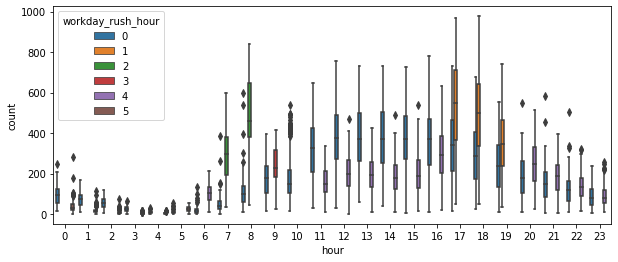

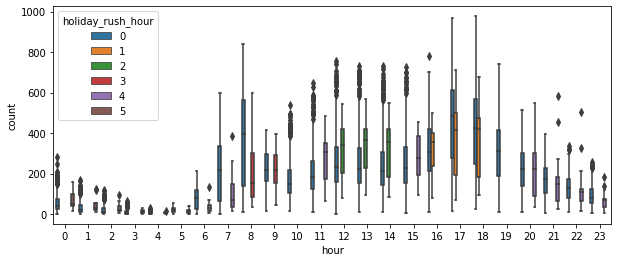

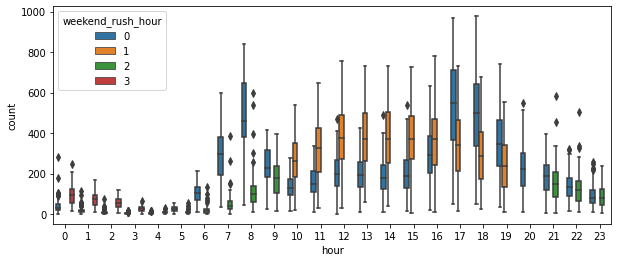

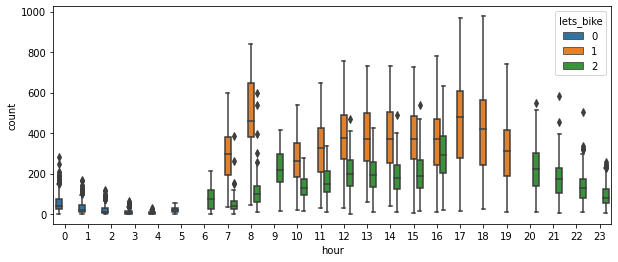

In [22]:
#sns.boxplot(x='hour', y='count', data=train, hue='workingday')
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='count', data=train, hue='workday_rush_hour')
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='count', data=train, hue='holiday_rush_hour')
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='count', data=train, hue='weekend_rush_hour')
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='count', data=train, hue='lets_bike')

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [47]:
# Set categorical datatype in train df
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["workingday"] = train["workingday"].astype("category")
train["holiday"] = train["holiday"].astype("category")

train["month"] = train["month"].astype("category")
train["day"] = train["day"].astype("category")
train["dow"] = train["dow"].astype("category")
train["holiday_rush_hour"] = train["holiday_rush_hour"].astype("category")
train["workday_rush_hour"] = train["workday_rush_hour"].astype("category")
train["weekend_rush_hour"] = train["weekend_rush_hour"].astype("category")
train["lets_bike"] = train["lets_bike"].astype("category")

# Set categorical datatype in test df
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["workingday"] = test["workingday"].astype("category")
test["holiday"] = test["holiday"].astype("category")

test["month"] = test["month"].astype("category")
test["day"] = test["day"].astype("category")
test["dow"] = test["dow"].astype("category")
test["holiday_rush_hour"] = test["holiday_rush_hour"].astype("category")
test["workday_rush_hour"] = test["workday_rush_hour"].astype("category")
test["weekend_rush_hour"] = test["weekend_rush_hour"].astype("category")
test["lets_bike"] = test["lets_bike"].astype("category")

In [16]:
# View the new feature
train.head()
train[train.windspeed==0].shape
train.describe()

temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159      8.474601     19.245033      8.164537     49.960477   
min        0.82000      0.760000      0.000000      0.000000      0.000000   
25%       13.94000     16.665000     47.000000      7.001500      4.000000   
50%       20.50000     24.240000     62.000000     12.998000     17.000000   
75%       26.24000     31.060000     77.000000     16.997900     49.000000   
max       41.00000     45.455000    100.000000     56.996900    367.000000   

         registered         count          hour          date  temp_ws_ratio  \
count  10886.000000  10886.000000  10886.000000  10886.000000   10886.000000   
mean     155.552177    191.574132     11.541613      9.992559       1.534270   
std      151.039033    181.144454      6.915838      5.476608       1.166119   
min        0.000000      1.000000      0.000000      1.000000       0.000000   
25%       36.000000     42.000000      6.000000      5.000000       0.702849   
50%      118.000000    145.000000     12.000000     10.000000       1.324819   
75%      222.000000    284.000000     18.000000     15.000000       2.161543   
max      886.000000    977.000000     23.000000     19.000000       6.419909   

       humidity_ws_ratio  
count       10886.000000  
mean            4.827939  
std             3.718836  
min             0.000000  
25%             2.105130  
50%             4.000615  
75%             6.908212  
max            16.657783

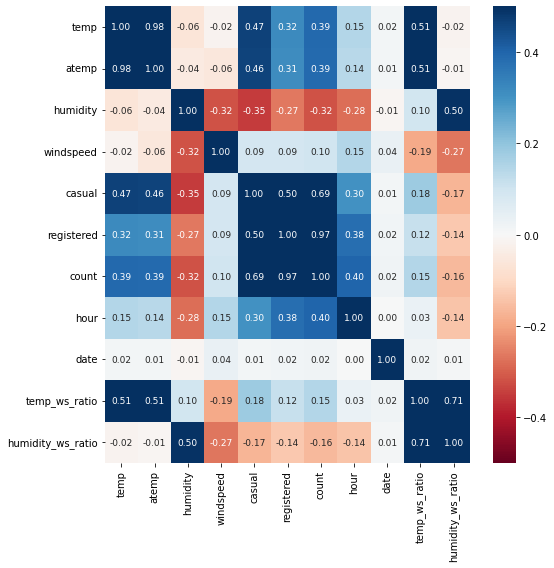

In [48]:
# Calculate correlation between the all features and the target
corr_df = train.corr()
save_df(corr_df, 'correlation_all_features_df')
corr_df

from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Use a diverging palette to visualize r
divnorm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
sns.heatmap(corr_df, annot=True, norm=divnorm, annot_kws={"size": 9}, fmt=".2f", ax=ax, cmap='RdBu')
plt.tight_layout()
save_fig('correlation_heatmap_all_features')

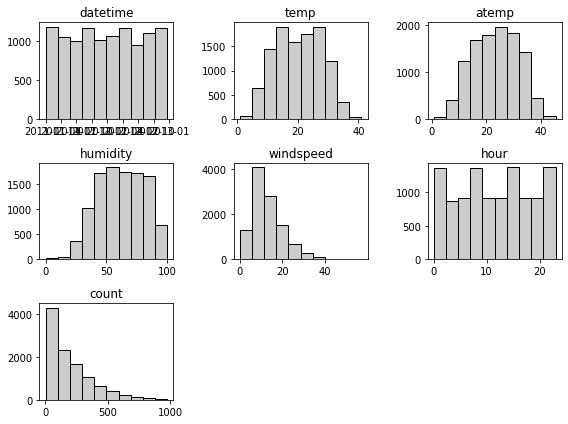

In [49]:
# View histogram of all features again now with the hour feature
feature_columns = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'count']
train[feature_columns].hist(color='0.8', edgecolor='k', grid=False, figsize=(8,6))

plt.tight_layout()
save_fig('data_distribution_histplot_final')

## Step 5: Rerun the model with the same settings as before, just with more features
**Run with one added feature (hour)**

In [20]:
feature_columns = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour','count']
predictor_new_features1 = TabularPredictor(problem_type="regression", eval_metric="root_mean_squared_error", label="count").fit(
    train_data=train[feature_columns],
    time_limit=600,
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220407_182003/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220407_182003/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3014.31 MB
	Train Data (Original)  Memory Usage: 0.57 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

In [22]:
predictor_new_features1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.993274      17.399959  549.382643                0.000686           0.352987            3       True         15
1          CatBoost_BAG_L2  -30.220445      15.874052  472.431859                0.118356          82.688646            2       True         13
2          LightGBM_BAG_L2  -30.353724      16.038427  412.713109                0.282731          22.969896            2       True         11
3        LightGBMXT_BAG_L2  -31.148991      16.498966  415.190391                0.743271          25.447177            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.346936      16.248748  397.634864                0.493052           7.891651            2       True         14
5   RandomForestMSE_BAG_L2  -31.519124      16.254915  417.923937         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.457273921492806,
  'LightGBM_BAG_L1': -

In [21]:
def autogluon_model_prediction(trained_model, test_df, feature_cols, model_name_str):
    '''
    Evaluates a model by predicting the target value, replaces negative predictions
    with zero when needed, and prepares and writes the Kaggle submission file to the
    current directory.
    '''
    prediction = trained_model.predict(test_df[feature_cols[:-1]])
    # If there are negative predictions, make them zero
    if prediction[prediction < 0].count()>0:
        prediction[prediction<0]=0

    # Prepare kaggle submission file
    submission_copy = submission[['datetime']].copy(deep=True)
    submission_copy["count"] = prediction
    out_csv_name = f"submission_{model_name_str}.csv"
    submission_copy.to_csv(out_csv_name, index=False)

In [23]:
# Prepare the kaggle submission file
autogluon_model_prediction(predictor_new_features1, test, feature_columns, 'new_features1')

In [24]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features1.csv -m "new features 1"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 330kB/s]
Successfully submitted to Bike Sharing DemandfileName                          date                 description           status    publicScore  privateScore  
--------------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features1.csv      2022-04-07 18:33:57  new features 1        complete  0.69214      0.69214       
submission_more_feature_3600.csv  2022-04-07 14:29:15  more_feature_3600     complete  0.76735      0.76735       
submission_new_features_ii.csv    2022-04-07 13:38:32  model_name_str        complete  0.68987      0.68987       
submission_new_features_ii.csv    2022-04-06 10:50:27  new features ii       complete  0.68987      0.68987       


#### New Score of 0.685

**Run with three added features**
- hour
- temp_ws_ratio
- humidity_ws_ratio

In [25]:
train.describe()

temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159      8.474601     19.245033      8.164537     49.960477   
min        0.82000      0.760000      0.000000      0.000000      0.000000   
25%       13.94000     16.665000     47.000000      7.001500      4.000000   
50%       20.50000     24.240000     62.000000     12.998000     17.000000   
75%       26.24000     31.060000     77.000000     16.997900     49.000000   
max       41.00000     45.455000    100.000000     56.996900    367.000000   

         registered         count          hour  temp_ws_ratio  \
count  10886.000000  10886.000000  10886.000000   10886.000000   
mean     155.552177    191.574132     11.541613       1.534270   
std      151.039033    181.144454      6.915838       1.166119   
min        0.000000      1.000000      0.000000       0.000000   
25%       36.000000     42.000000      6.000000       0.702849   
50%      118.000000    145.000000     12.000000       1.324819   
75%      222.000000    284.000000     18.000000       2.161543   
max      886.000000    977.000000     23.000000       6.419909   

       humidity_ws_ratio  
count       10886.000000  
mean            4.827939  
std             3.718836  
min             0.000000  
25%             2.105130  
50%             4.000615  
75%             6.908212  
max            16.657783

<AxesSubplot:xlabel='humidity_ws_ratio', ylabel='count'>

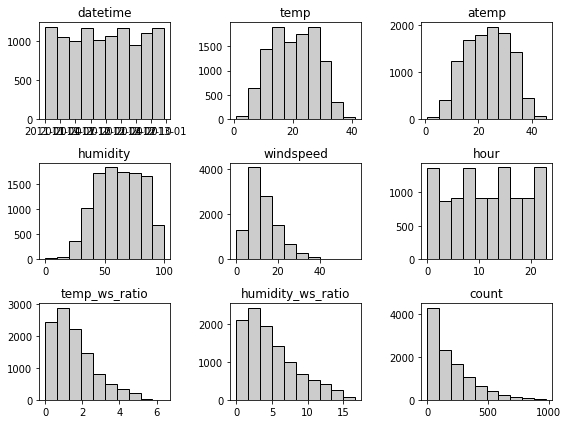

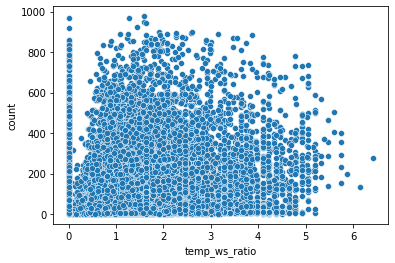

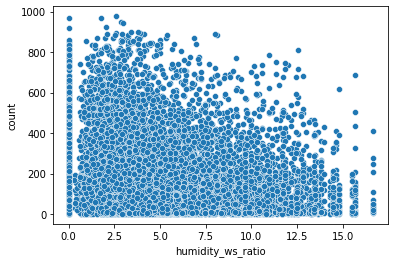

In [87]:
# View histogram of all features again now with the hour feature
feature_columns = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio', 'count']
train[feature_columns].hist(color='0.8', edgecolor='k', grid=False, figsize=(8,6))

plt.tight_layout()
save_fig('data_distribution_histplot_newfeatures_final')

plt.figure()
sns.scatterplot(x='temp_ws_ratio', y='count', data=train)
plt.figure()
sns.scatterplot(x='humidity_ws_ratio', y='count', data=train)

In [26]:
feature_columns_3 = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio', 'count']

predictor_new_features3 = TabularPredictor(problem_type="regression", eval_metric="root_mean_squared_error", label="count").fit(
    train_data=train[feature_columns_3],
    time_limit=600,
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220407_183548/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220407_183548/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2426.71 MB
	Train Data (Original)  Memory Usage: 0.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

<AxesSubplot:xlabel='model'>

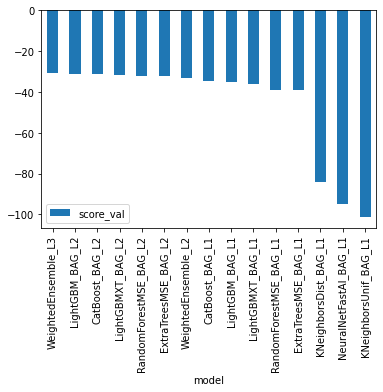

In [27]:
predictor_new_features3.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [28]:
predictor_new_features3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.684720      13.827981  557.096758                0.000746           0.332625            3       True         15
1          LightGBM_BAG_L2  -31.016838      12.100480  419.005697                0.285749          24.270530            2       True         11
2          CatBoost_BAG_L2  -31.074246      11.937082  470.367383                0.122350          75.632215            2       True         13
3        LightGBMXT_BAG_L2  -31.646798      12.918194  425.694667                1.103463          30.959500            2       True         10
4   RandomForestMSE_BAG_L2  -32.128501      12.315672  425.901888                0.500941          31.166721            2       True         12
5     ExtraTreesMSE_BAG_L2  -32.280237      12.318978  403.067608         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -35.88990724948389,
  'LightGBM_BAG_L1': -3

In [29]:
# Prepare the kaggle submission file
autogluon_model_prediction(predictor_new_features3, test, feature_columns_3, 'new_features3')


In [30]:
# Submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features3.csv -m "new features 3"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 467kB/s]
Successfully submitted to Bike Sharing DemandfileName                          date                 description           status    publicScore  privateScore  
--------------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features3.csv      2022-04-07 18:49:53  new features 3        complete  0.67018      0.67018       
submission_new_features1.csv      2022-04-07 18:33:57  new features 1        complete  0.69214      0.69214       
submission_more_feature_3600.csv  2022-04-07 14:29:15  more_feature_3600     complete  0.76735      0.76735       
submission_new_features_ii.csv    2022-04-07 13:38:32  model_name_str        complete  0.68987      0.68987       


## Use all added features

In [161]:
feature_columns_all =  ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'date', 'month', 'dow', 'day', 'holiday_rush_hour',
       'workday_rush_hour', 'weekend_rush_hour', 'lets_bike', 'temp_ws_ratio',
       'humidity_ws_ratio', 'count']

predictor_new_features_all = TabularPredictor(problem_type="regression", eval_metric="root_mean_squared_error", label="count").fit(
    train_data=train[feature_columns_all],
    time_limit=600,
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220408_233139/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220408_233139/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1766.97 MB
	Train Data (Original)  Memory Usage: 0.83 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

In [20]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'date', 'month', 'dow', 'day', 'holiday_rush_hour',
       'workday_rush_hour', 'weekend_rush_hour', 'lets_bike', 'temp_ws_ratio',
       'humidity_ws_ratio'],
      dtype='object')

In [162]:
predictor_new_features_all.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.535421      14.694994  536.896514                0.000995           0.489047            3       True         15
1          LightGBM_BAG_L2  -30.851123      12.440905  421.503730                0.496608          25.566223            2       True         11
2          CatBoost_BAG_L2  -30.965707      12.101587  467.724322                0.157290          71.786815            2       True         13
3        LightGBMXT_BAG_L2  -31.640713      13.505958  430.173587                1.561661          34.236079            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.807428      12.478440  404.818350                0.534143           8.880843            2       True         14
5   RandomForestMSE_BAG_L2  -32.193127      12.487837  428.473013         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -35.805614916462964,
  'LightGBM_BAG_L1': -

In [ ]:
# Prepare the kaggle submission file
autogluon_model_prediction(predictor_new_features_all, test, feature_columns_all, 'new_features_all')

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features_all.csv -m "new features all"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

In [ ]:
predictor_new_features_all.feature_importance(train[feature_columns_all])

***Best score so far | 0.67 with three new features***

### Try the best model with transformed data ###

In [39]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio', 'count']
features_for_transform = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio']

# Transform train
train_zt = train.copy(deep=True)
zscaler = StandardScaler()
zscaler.fit(train_zt[features_for_transform])
train_zt[features_for_transform] = zscaler.transform(train_zt[features_for_transform])

#Transform test (Use the train scaler)
zscaler = StandardScaler()
test_zt = test.copy(deep=True)
test_zt[features_for_transform] = zscaler.fit_transform(test_zt[features_for_transform])

In [33]:
#Check the z-transform
train_zt.describe()

temp         atemp      humidity     windspeed        casual  \
count  1.088600e+04  1.088600e+04  1.088600e+04  1.088600e+04  10886.000000   
mean   3.133020e-16 -2.193114e-16  1.148774e-16 -5.221699e-17     36.021955   
std    1.000046e+00  1.000046e+00  1.000046e+00  1.000046e+00     49.960477   
min   -2.491372e+00 -2.701736e+00 -3.215858e+00 -1.567754e+00      0.000000   
25%   -8.074281e-01 -8.248654e-01 -7.735577e-01 -7.101642e-01      4.000000   
50%    3.454398e-02  6.902305e-02  5.899992e-03  2.432639e-02     17.000000   
75%    7.712696e-01  8.738177e-01  7.853577e-01  5.142603e-01     49.000000   
max    2.665707e+00  2.572501e+00  1.980526e+00  5.413599e+00    367.000000   

         registered         count          hour  temp_ws_ratio  \
count  10886.000000  10886.000000  1.088600e+04   1.088600e+04   
mean     155.552177    191.574132  6.657667e-17   1.462076e-16   
std      151.039033    181.144454  1.000046e+00   1.000046e+00   
min        0.000000      1.000000 -1.668944e+00  -1.315767e+00   
25%       36.000000     42.000000 -8.013299e-01  -7.130140e-01   
50%      118.000000    145.000000  6.628379e-02  -1.796220e-01   
75%      222.000000    284.000000  9.338975e-01   5.379400e-01   
max      886.000000    977.000000  1.656909e+00   4.189852e+00   

       humidity_ws_ratio  
count       1.088600e+04  
mean        2.610850e-17  
std         1.000046e+00  
min        -1.298299e+00  
25%        -7.322006e-01  
50%        -2.224786e-01  
75%         5.594139e-01  
max         3.181207e+00

Transformation of the features looks OK. As expected, the mean and std of the features are 0 and 1.

In [34]:
feature_columns_3zt = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio', 'count']

predictor_new_features3zt = TabularPredictor(problem_type="regression", eval_metric="root_mean_squared_error", label="count").fit(
    train_data=train_zt[feature_columns_3zt],
    time_limit=600,
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220407_190433/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220407_190433/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2049.74 MB
	Train Data (Original)  Memory Usage: 0.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.704059      12.853007  530.594147                0.000672           0.356835            3       True         15
1          CatBoost_BAG_L2  -30.953021      11.268848  470.898709                0.150811          73.051276            2       True         13
2          LightGBM_BAG_L2  -31.092314      11.408341  423.547217                0.290304          25.699785            2       True         11
3        LightGBMXT_BAG_L2  -31.724287      12.411220  431.486251                1.293183          33.638819            2       True         10
4     ExtraTreesMSE_BAG_L2  -32.142740      11.613506  406.344726                0.495469           8.497294            2       True         14
5   RandomForestMSE_BAG_L2  -32.373658      11.620510  429.801140         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -35.77940201596305,
  'LightGBM_BAG_L1': -3

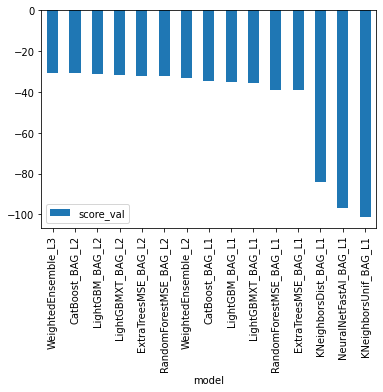

In [36]:
predictor_new_features3zt.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")
predictor_new_features3zt.fit_summary()

In [40]:
# Prepare the kaggle submission file
autogluon_model_prediction(predictor_new_features3zt, test_zt, feature_columns_3zt, 'new_features3zt')

In [41]:
# Submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features3zt.csv -m "new features 3zt"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 410kB/s]
Successfully submitted to Bike Sharing DemandfileName                          date                 description           status    publicScore  privateScore  
--------------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features3zt.csv    2022-04-07 19:18:48  new features 3zt      complete  0.69519      0.69519       
submission_new_features3zt.csv    2022-04-07 19:16:32  new features 3zt      complete  0.70019      0.70019       
submission_new_features3.csv      2022-04-07 18:49:53  new features 3        complete  0.67018      0.67018       
submission_new_features1.csv      2022-04-07 18:33:57  new features 1        complete  0.69214      0.69214       


***Best score so far | 0.67 with three new features without feature transformation***
The new score with transformation: 0.70 (Apply train transformer to test data)
The new score with transformation: 0.695 (separate transformers for train and test data)

As teh score didn't increase with transformation, we will use the un-transformed features in the model training with HPO 
*********************************


## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [42]:
import autogluon.core as ag

nn_options = {'num_epochs': 50, 
              'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True), 
              'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
              'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)
             }

gbm_options = {'num_boost_round': 100,
               'num_leaves': ag.space.Int(lower=25, upper=70, default=36)
               }

hyperparameters = {'GBM': gbm_options,
                   'NN_TORCH': nn_options
                  }

hyperparameter_tune_kwargs = {'num_trials': 10,
                              'scheduler' : 'local',
                              'searcher': 'auto'}

feature_columns_hpo = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'temp_ws_ratio', 'humidity_ws_ratio', 'count']

#predictor_new_hpo = TabularPredictor().fit(?)
predictor_new_hpo = TabularPredictor(label='count',
                      problem_type='regression',
                     eval_metric = 'root_mean_squared_error').fit(
    train_data = train[feature_columns_hpo],
    time_limit = 3600,
    presets = 'best_quality',
    holdout_frac = 0.3,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220407_192439/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20220407_192439/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1964.31 MB
	Train Data (Original)  Memory Usage: 0.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identit

<AxesSubplot:xlabel='model'>

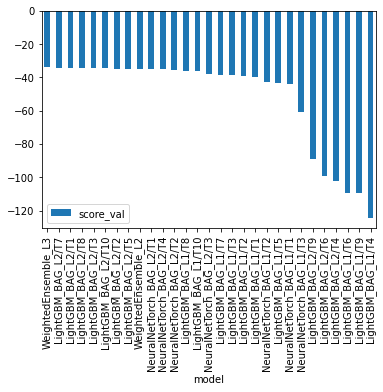

In [43]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [44]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -33.969189       8.920215  2711.849366                0.000817           0.736907            3       True         29
1         LightGBM_BAG_L2/T7  -34.400793       6.080886  1694.240690                0.129651          16.934681            2       True         21
2         LightGBM_BAG_L2/T1  -34.553061       6.082382  1694.649745                0.131147          17.343735            2       True         15
3         LightGBM_BAG_L2/T8  -34.600892       6.069487  1695.658434                0.118252          18.352425            2       True         22
4         LightGBM_BAG_L2/T3  -34.608185       6.094599  1695.906045                0.143364          18.600035            2       True         17
5        LightGBM_BAG_L2/T10  -34.640056       6.060920 

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T3': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'Stack

In [98]:
# Prepare the kaggle submission file
autogluon_model_prediction(predictor_new_hpo, test, feature_columns_hpo, 'new_hpo')

In [99]:
# Submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features_hpo.csv -m "new features with hyperparameters"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 361kB/s]
Successfully submitted to Bike Sharing DemandfileName                          date                 description                        status    publicScore  privateScore  
--------------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features_hpo.csv   2022-04-07 22:15:52  new features with hyperparameters  complete  0.45218      0.45218       
submission_new_features_hpo.csv   2022-04-07 20:22:17  new features hpo                   complete  0.45218      0.45218       
submission_new_features3zt.csv    2022-04-07 19:18:48  new features 3zt                   complete  0.69519      0.69519       
submission_new_features3zt.csv    2022-04-07 19:16:32  new features 3zt                   complete  0.70019      0.70019       


### New score of 0.45
The highest score so far!

### Feature importance

In [100]:
predictor_new_hpo.feature_importance(train[feature_columns_hpo])

Computing feature importance via permutation shuffling for 12 features using 1000 rows with 3 shuffle sets...
	276.91s	= Expected runtime (92.3s per shuffle set)
	138.29s	= Actual runtime (Completed 3 of 3 shuffle sets)


importance    stddev   p_value  n    p99_high     p99_low
hour               186.046516  5.135115  0.000127  3  215.471295  156.621737
datetime            81.238154  6.389656  0.001028  3  117.851589   44.624718
workingday          47.859453  4.201212  0.001279  3   71.932862   23.786045
temp                23.561928  1.263295  0.000478  3   30.800751   16.323105
humidity            18.845987  2.697589  0.003380  3   34.303469    3.388505
weather             11.871298  0.657905  0.000511  3   15.641165    8.101431
atemp                8.421055  1.713591  0.006762  3   18.240124   -1.398013
season               2.155834  0.922316  0.027970  3    7.440807   -3.129139
humidity_ws_ratio    1.898378  0.232505  0.002481  3    3.230657    0.566099
temp_ws_ratio        1.670637  0.047231  0.000133  3    1.941276    1.399998
windspeed            1.517412  0.261896  0.004892  3    3.018103    0.016720
holiday              1.217809  0.170152  0.003222  3    2.192797    0.242820

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

              model  score
0           initial  52.80
1    add_features_1  29.99
2    add_features_3  30.68
3  add_features_3zt  30.70
4               hpo  33.96
          test_eval  score
0           initial   1.80
1    add_features_1   0.68
2    add_features_3   0.67
3  add_features_3zt   0.70
4               hpo   0.45


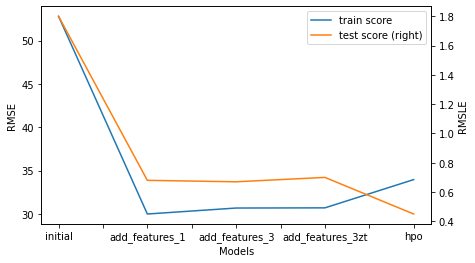

In [50]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
train_score_df = pd.DataFrame(
    {
    "model": ["initial", "add_features_1", "add_features_3", "add_features_3zt", "hpo"],
    "score": [52.80, 29.99, 30.68, 30.70, 33.96],
    })

test_score_df = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features_1", "add_features_3", "add_features_3zt", "hpo"],
        "score": [1.80, 0.68, 0.67, 0.70, 0.45]
    }
)


# Plot a figure with train and test scores
fig, ax = plt.subplots(1,1, figsize=(7, 4))
train_score_df.plot(x="model", y="score", ax=ax, label='train score')
test_score_df.plot(x="test_eval", y="score", ax=ax, secondary_y=True, label='test score')

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.right_ax.set_ylabel('RMSLE')
save_fig('model_train_test_score')
print(train_score_df)
print(test_score_df)

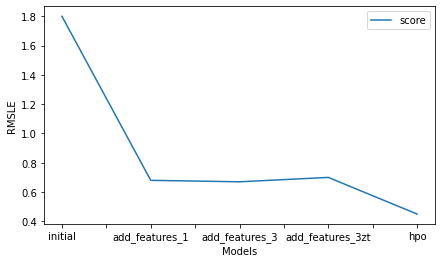

In [52]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features_1", "add_features_3", "add_features_3zt", "hpo"],
        "score": [1.80, 0.68, 0.67, 0.70, 0.45]
    }
).plot(x="test_eval", y="score", figsize=(7, 4)).get_figure()

plt.xlabel('Models')
plt.ylabel('RMSLE')
save_fig('model_test_score')

### Hyperparameter table

In [51]:
# The 3 hyperparameters we tuned with the kaggle score as the result
# WeightedEnsemble_L3 was the top models on all runs
hyperpar_df = pd.DataFrame({
    "model": ["initial", "add_features_1", "add_features_3", "add_features_3zt", "hpo"],
    "Val_frac": [0.1, 0.1, 0.1, 0.1, 0.1],
    "presets": ["Best quality", "Best quality", "Best quality", "Best quality", "Best quality"],
    "score": [1.80, 0.68, 0.67, 0.70, 0.45]
})

save_df(hyperpar_df, 'hyperparameter_table')
hyperpar_df

model  Val_frac       presets  score
0           initial       0.1  Best quality   1.80
1    add_features_1       0.1  Best quality   0.68
2    add_features_3       0.1  Best quality   0.67
3  add_features_3zt       0.1  Best quality   0.70
4               hpo       0.1  Best quality   0.45